In [ ]:
from google.colab import files
uploaded= files.upload()

Saving FlightFare_Cleaned.csv to FlightFare_Cleaned.csv


In [ ]:
import pandas as pd
df=pd.read_csv('FlightFare_Cleaned.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,zscore
0,0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,-0.658068
1,1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,-0.658068
2,2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,-0.657936
3,3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,-0.657980
4,4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,-0.657980


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# Caricamento del dataset
df = pd.read_csv("FlightFare_Cleaned.csv")

# Eliminazione di colonne non necessarie
columns_to_drop = ["Unnamed: 0.1", "Unnamed: 0", "zscore"]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1, inplace=True)

# Riduzione del dataset al 30% per risparmiare memoria
df_sampled = df.sample(frac=0.3, random_state=42)

# Separare features e target
X_sampled = df_sampled.drop(["price"], axis=1)
y_sampled = df_sampled["price"]

# Applicare Label Encoding alle variabili categoriche
categorical_cols = X_sampled.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_sampled[col] = le.fit_transform(X_sampled[col])
    label_encoders[col] = le

# Divisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.30, random_state=42)

# Normalizzazione
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definizione della griglia di ricerca per Random Forest
rf = RandomForestRegressor(random_state=42)



In [ ]:
param_grid_rf = {
    "n_estimators": [50, 100],  # Numero di alberi
    "max_depth": [10, 20],  # Profondità massima
    "min_samples_split": [2, 5],  # Minimo numero di campioni per split
    "min_samples_leaf": [1, 2]  # Minimo numero di campioni in una foglia
}

# Eseguire GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, n_jobs=-1, verbose=2, scoring="r2")
grid_search_rf.fit(X_train, y_train)

# Ottenere i migliori iperparametri trovati
best_params_rf = grid_search_rf.best_params_
print("Migliori iperparametri per Random Forest:", best_params_rf)


=== Valutazione del modello Random Forest Ottimizzato ===
MAE: 1194.26
MSE: 6669614.13
RMSE: 2582.56
R2 Score: 0.9869


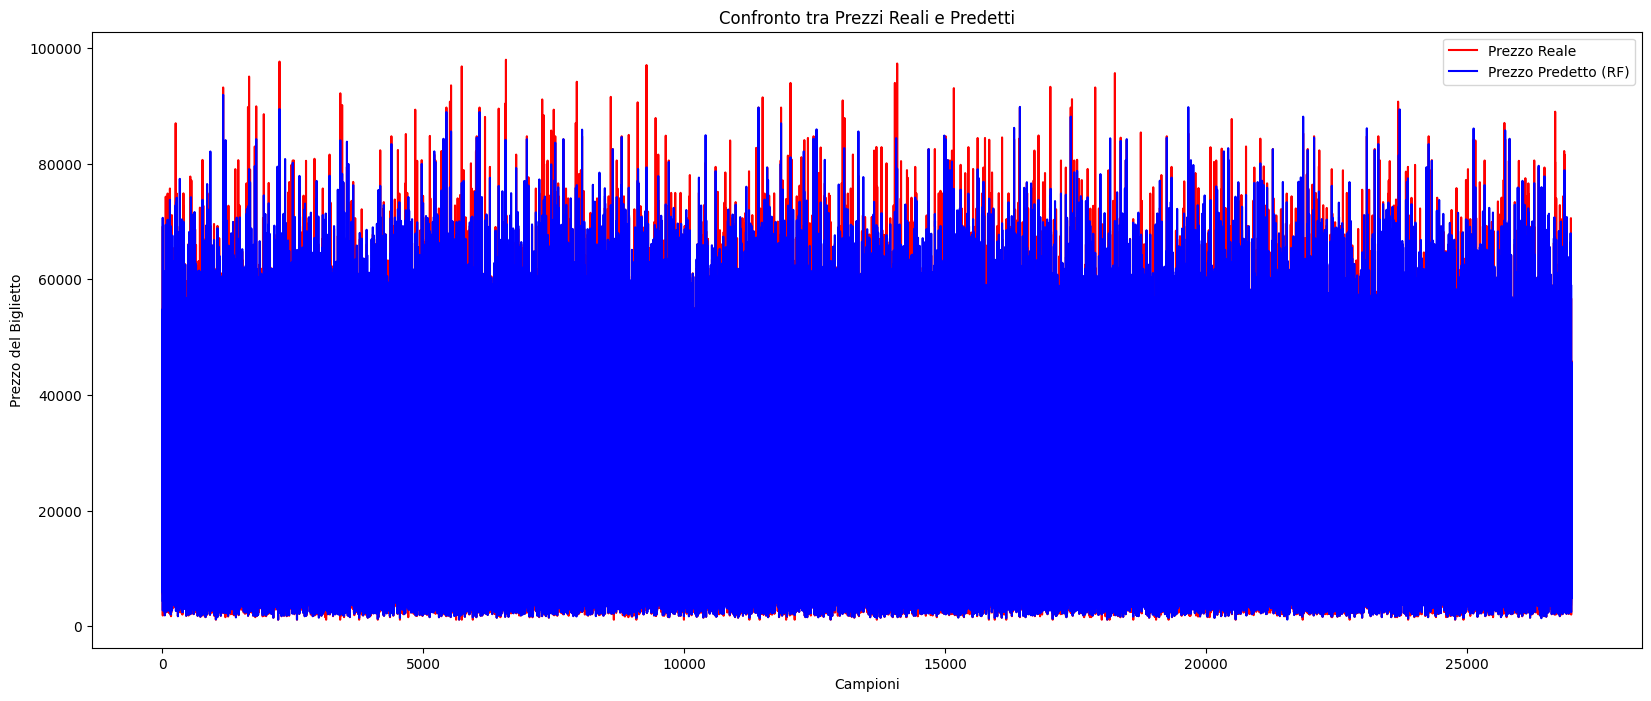

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Addestrare il modello Random Forest con i migliori iperparametri
best_rf = RandomForestRegressor(
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)

best_rf.fit(X_train, y_train)

# Predire i prezzi con il modello ottimizzato
y_pred = best_rf.predict(X_test)

# Funzione per calcolare e stampare le metriche
def print_metrics(y_true, y_pred, model_name):
    print(f"\n=== Valutazione del modello {model_name} ===")
    print("MAE:", round(mean_absolute_error(y_true, y_pred), 2))
    print("MSE:", round(mean_squared_error(y_true, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 2))
    print("R2 Score:", round(r2_score(y_true, y_pred), 4))

# Stampare le metriche del modello ottimizzato
print_metrics(y_test, y_pred, "Random Forest Ottimizzato")

# Confronto tra prezzi reali e predetti
plt.figure(figsize=(20, 8))

sns.lineplot(x=range(len(y_test)), y=y_test, color="red", label="Prezzo Reale")
sns.lineplot(x=range(len(y_pred)), y=y_pred, color="blue", label="Prezzo Predetto (RF)")

plt.xlabel("Campioni")
plt.ylabel("Prezzo del Biglietto")
plt.title("Confronto tra Prezzi Reali e Predetti")
plt.legend()
plt.show()


In [ ]:
with open("scaler_and_encoders.pkl", "wb") as f:
    pickle.dump((scaler, label_encoders), f)


In [ ]:
# Stima del prezzo tra 7 giorni
X_test_future = X_test.copy()

# Ottenere l'indice della colonna 'days_left'
days_left_index = df_sampled.drop("price", axis=1).columns.get_loc("days_left")

# Sottrarre 7 giorni
X_test_future[:, days_left_index] -= 7

# Assicurarsi che i valori non vadano sotto zero
X_test_future[:, days_left_index] = np.maximum(X_test_future[:, days_left_index], 0)

# Normalizzare nuovamente con lo stesso scaler
X_test_future = scaler.transform(X_test_future)

# Predizione dei prezzi futuri
price_future_predictions = best_rf.predict(X_test_future)

# Decisione basata sul confronto dei prezzi
decision = np.where(price_future_predictions < y_pred, "Sì, aspetta", "No, prenota")

# Output di esempio
for i in range(10):
    print(f"Prezzo attuale: {y_pred[i]:.2f}, Prezzo stimato: {price_future_predictions[i]:.2f}, Decisione: {decision[i]}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Prezzo attuale: 44167.93, Prezzo stimato: 12050.10, Decisione: Sì, aspetta
Prezzo attuale: 49673.96, Prezzo stimato: 12050.10, Decisione: Sì, aspetta
Prezzo attuale: 54684.00, Prezzo stimato: 12050.10, Decisione: Sì, aspetta
Prezzo attuale: 6182.79, Prezzo stimato: 8208.70, Decisione: No, prenota
Prezzo attuale: 54777.00, Prezzo stimato: 12051.24, Decisione: Sì, aspetta
Prezzo attuale: 5946.05, Prezzo stimato: 9179.15, Decisione: No, prenota
Prezzo attuale: 6114.78, Prezzo stimato: 9075.00, Decisione: No, prenota
Prezzo attuale: 70642.75, Prezzo stimato: 12050.10, Decisione: Sì, aspetta
Prezzo attuale: 2701.31, Prezzo stimato: 8297.47, Decisione: No, prenota
Prezzo attuale: 7671.11, Prezzo stimato: 8616.77, Decisione: No, prenota


In [ ]:
import pickle

# Salva il modello addestrato con pickle
with open('flight_price_predictor.pkl', 'wb') as f:
    pickle.dump(best_rf, f)


In [ ]:
from google.colab import files
files.download("flight_price_predictor.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("scaler_and_encoders.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>